In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('financial news dataset.csv',names=['Label','Headline'], encoding='ISO-8859-1')

In [3]:
dataset.head(10)

,Label,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     4846 non-null   object
 1   Headline  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


## Preprocessing

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#Remove blank row if any
dataset['Headline'].dropna(inplace=True)

#Change all the text to lower case
dataset['Headline'] = [entry.lower() for entry in dataset['Headline']]

#Tokenization
dataset['Headline'] = [word_tokenize(entry) for entry in dataset['Headline']]

In [7]:
#Post Tagging
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [8]:
for index, entry in enumerate(dataset['Headline']) :
    #Declaring Empty List
    Final_words = []
    #Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(entry):
        #Check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index,'Headline_final'] = str(Final_words)

##  Data Snippet After Lemmatization.

In [9]:
dataset.head(10)

,Label,Headline,Headline_final
0,neutral,"[according, to, gran, ,, the, company, has, no...","['accord', 'gran', 'company', 'plan', 'move', ..."
1,neutral,"[technopolis, plans, to, develop, in, stages, ...","['technopolis', 'plan', 'develop', 'stage', 'a..."
2,negative,"[the, international, electronic, industry, com...","['international', 'electronic', 'industry', 'c..."
3,positive,"[with, the, new, production, plant, the, compa...","['new', 'production', 'plant', 'company', 'wou..."
4,positive,"[according, to, the, company, 's, updated, str...","['accord', 'company', 'updated', 'strategy', '..."
5,positive,"[financing, of, aspocomp, 's, growth, aspocomp...","['financing', 'aspocomp', 'growth', 'aspocomp'..."
6,positive,"[for, the, last, quarter, of, 2010, ,, compone...","['last', 'quarter', 'componenta', 'net', 'sale..."
7,positive,"[in, the, third, quarter, of, 2010, ,, net, sa...","['third', 'quarter', 'net', 'sale', 'increase'..."
8,positive,"[operating, profit, rose, to, eur, 13.1, mn, f...","['operating', 'profit', 'rise', 'eur', 'mn', '..."
9,positive,"[operating, profit, totalled, eur, 21.1, mn, ,...","['operating', 'profit', 'total', 'eur', 'mn', ..."


## Exploratory Data Analysis

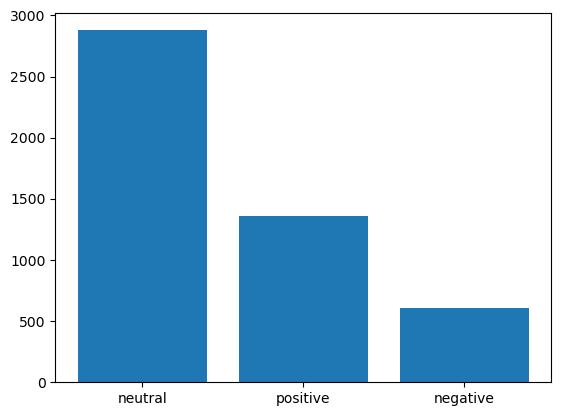

In [10]:
fig, ax = plt.subplots()
ax = plt.bar(['neutral','positive','negative'], dataset['Label'].value_counts().values)


The data is unbalanced. To avoid bias, the data needs to be balanced so that the number of instances in each category is the same.

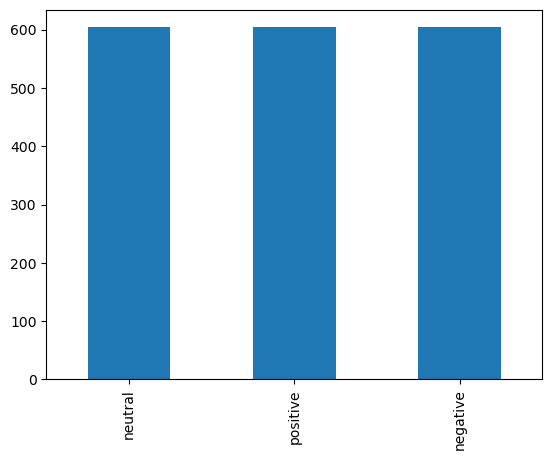

In [11]:
#Class count
count_neutral, count_positive, count_negative = dataset.Label.value_counts()

#Divide by class
dataset_neutral = dataset[dataset['Label'] == 'neutral']
dataset_positive = dataset[dataset['Label'] == 'positive']
dataset_negative = dataset[dataset['Label'] == 'negative']

dataset_neutral_under = dataset_neutral.sample(count_negative)
dataset_positive_under = dataset_positive.sample(count_negative)

dataset_balance = pd.concat([dataset_neutral_under, dataset_positive_under, dataset_negative], axis=0)
dataset_balance.Label.value_counts().plot(kind='bar');

In [12]:
dataset_balance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1812 entries, 1354 to 4845
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Label           1812 non-null   object
 1   Headline        1812 non-null   object
 2   Headline_final  1812 non-null   object
dtypes: object(3)
memory usage: 56.6+ KB


After balancing, the total number of data used is 604 data in each category.

## Splitting Data 

The data is divided into training and testing data. The proportion of data for testing is 30%.

In [13]:
#Split the model into Train and Test Dataset

X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset_balance['Headline_final'],dataset_balance['Label'],test_size=0.3)

## Tf-Idf Vectorizing 

Converting string data in the target variable into numerical values.

In [14]:
#Label encode the target variable
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

Vectorizing words in the training data using TF-IDF to determine the importance of words within a document.

In [15]:
#Vectorize the words by using Tf-Idf Vectorizer
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset_balance['Headline_final'])
X_train_Tfidf = Tfidf_vect.transform(X_train)

## Build SVM Model & Train Data 

Building an SVM model with a linear kernel and a penalty parameter of 1. Training the data with the constructed model.

In [16]:
#Classifier - Algorithm - SVM 
#fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear',degree=3, gamma='auto',random_state=42)
SVM.fit(X_train_Tfidf,y_train)

SVC(gamma='auto', kernel='linear', random_state=42)

In [17]:
#predict the labels on validation dataset
X_test_Tfidf = Tfidf_vect.transform(X_test)
predictions_SVM = SVM.predict(X_test_Tfidf)

## Test the Accuracy 

In [18]:
#Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM,y_test)*100)

SVM Accuracy Score ->  69.11764705882352


In [19]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,predictions_SVM,target_names=['negative','positive','neutral'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    negative       0.76      0.70      0.73       183
    positive       0.62      0.78      0.69       179
     neutral       0.72      0.59      0.65       182

    accuracy                           0.69       544
   macro avg       0.70      0.69      0.69       544
weighted avg       0.70      0.69      0.69       544



## Cross Validation 

In [20]:
X_Tfidf = Tfidf_vect.transform(dataset_balance['Headline_final'])
y = Encoder.fit_transform(dataset_balance['Label'])

from sklearn.model_selection import cross_val_score
scores = cross_val_score(SVM, X_Tfidf, y, cv=5)

print(scores)

print("%0.2f accuracy with a standard deviation of %0.2f" %(scores.mean(), scores.std()))

[0.63085399 0.66942149 0.62983425 0.72375691 0.66574586]
0.66 accuracy with a standard deviation of 0.03


Cross-validation is performed by dividing the data into 5 folds and conducting training 5 times. The accuracy results from each training process are 0.60881543, 0.63636364, 0.62983425, 0.70165746, and 0.68508287. As a result, the average accuracy of 65% is obtained with a standard deviation of 0.04.